# Статистичский анализ сервиса GoFast

***Краткое описание:*** Мы являемся аналитиками сервиса GoFast(аренда самокатов) и нам нужно проанализировать данные о пользвателях и совершенных ими поездках, чтобы понять, как мы можем улучшить  бизнес и помочь ему расти💸📈! У наших продакт-менеджеров есть предположения о различиях польователей с подпиской и без неё, и нам нужно понять какие все таки более выгодные и приносят больше прибыли. 

***Цель:*** Задачей этого исследования является изучение данных о поездках и пользователей услуги GoFast. Нам предстоить познакомится с тремя файлами о пользователях, их поездках, а также подробной информации о подписках и на основе полученных данных проверить статистические гипотезы. Для чего нам это необходимо? Конечно же, чтобы улучшить работу нашего бизнеса!

***План работы:*** 
1) Итак, получив исходные данные, познакомимся с ними поближе и более подробно изучим информацию по ним. 

2) Далее проверим корректность данных, а именно присутсвие дубликатов, как явных, так и неявных, убедимся, что нет пропущенных значений и по необходимости все исправим! 

3) Также необходимо взглянуть на основные параметры поездок такие как: длительность, расстояние, в каком городе были совершены и др. Построим и опишем графики этих характеристик.

4) Т.к. исходные данные у нас не разделены, взглянем как ведут себя параметры у пользователей с подпиской и без неё. Сравним полученные графики, посмотрим на различия, если они будут.

5) После изучения данных, самое время помочь бизнесу вырасти! Рассчитаем выручку по месяцам для каждого пользователя.

6) После подсчета выручки, проверим насколько "хороши" пользователи с подпиской для бизнеса. Проверять мы будем  гипотезы, а точнее предположения наших продакт-менеджеров.

Но перед началом, конечно же импортируем необходимые нам библиотеки!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

## Загрузка данных

Открываем и сохраняем данные

In [2]:
users_go = pd.read_csv('Downloads/users_go.csv')
riders_go = pd.read_csv('Downloads/rides_go.csv')
subscriptions_go = pd.read_csv('Downloads/subscriptions_go.csv')

Знакомимся с первыми строчками датафреймов

In [3]:
display(users_go.head(10),
riders_go.head(10),
subscriptions_go.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Изучаем общую информацию о каждом датасете

In [4]:
display(users_go.info(),
        riders_go.info(), 
        subscriptions_go.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Col

None

None

None

По итогам загрузки данных: 

    1) Как таковых пропусков нет;
    
    2) Некорректный тип данных в столбце date в датафрейме riders_go;
    
    3) Кол-во строк в таблицах user_id и riders_go сильно разняться т.к. стоит понимать, что данные в столцбе user_id в датафрейме riders_go могу соддержать повторяющиеся значения, один и тот же пользователь может совершать несколько поездок.

## Предобработка данных

Приводим столбец data в датафрейме riders_go к типу дата

In [5]:
riders_go['date'] = pd.to_datetime(riders_go['date'], format='%Y-%m-%d')

Далее создаём новый столбец month на основе столбца date в таблице riders_go, также добавим столбце с годом, чтобы понять за какой период мы будем проверять данные.

In [6]:
riders_go['month'] = pd.DatetimeIndex(riders_go['date']).month
riders_go['year'] = pd.DatetimeIndex(riders_go['date']).year

Проверим за какой год исходные данные

In [7]:
riders_go['year'].value_counts()

year
2021    18068
Name: count, dtype: int64

Отлично! данные о поездках только за 2021. Смотрим дальше

Проверяем наличие пропущенных значений и дубликатов в каждом датафрейме

In [8]:
print(users_go.isna().sum(),
      riders_go.isna().sum(),
      subscriptions_go.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64 user_id     0
distance    0
duration    0
date        0
month       0
year        0
dtype: int64 subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


In [9]:
users_go.duplicated().sum()

31

In [10]:
users_go['user_id'].duplicated().sum()

31

In [11]:
users_go = users_go.drop_duplicates(subset=['user_id'],keep='first')

In [12]:
users_go['user_id'].duplicated().sum()

0

In [13]:
riders_go.duplicated().sum()

0

Также можно проверить столбец city в users_go на неявные дубликаты

In [14]:
users_go['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [15]:
users_go.head(5)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


По итогам предобработки данных:
    
    1) Скорректировали тип данных в столбце date
    
    2) Добавили новый столбец с номером месяца по столбцу date
    
    3) Проверили датафреймы на наличие дубликатов и удалили только 31 строку в таблице users_go
    
    4) Также удостоверились, что все города написаны правильно и неявных дубликатов нет.

## Исследовательский анализ данных

Далее проведем исследовательский анализ, визуализируем несколько столбцов и опишем данные

Для начала взглянем на частоту встречаемости городов

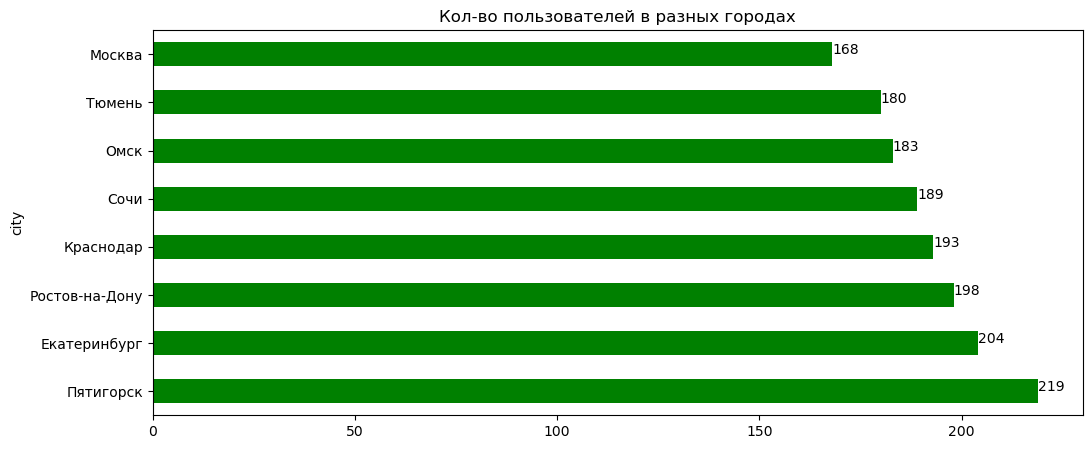

In [16]:
city_counts = users_go['city'].value_counts()
city_counts.plot.barh(title='Кол-во пользователей в разных городах',color='green',figsize=(12,5))
for index, value in enumerate(city_counts):
    plt.text(value, index, str(value));

На данной диаграмме видим, что явных фаворитов и аутсайдеров в городах нет. Наибольшую долю городов составляет Пятигорск 219 пользователей c небольшим отрывом (в 15 пользователей) от Екатеринбурга, в то время как наименьшее кол-во поездок в Москве 168 пользователей.

Расссмотрим также круговую диаграмму соотношения пользователей с подпиской и без неё

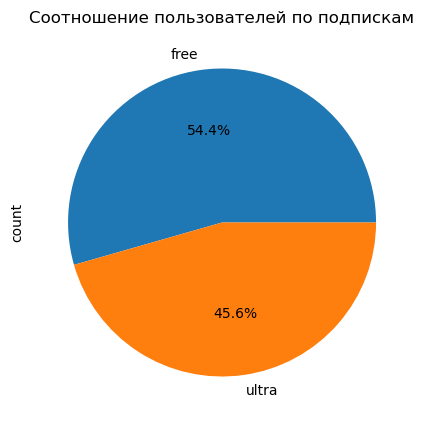

In [17]:
users_go['subscription_type'].value_counts().plot(kind='pie',figsize=(5,5),title='Соотношение пользователей по подпискам',autopct='%1.1f%%')
plt.show()

На диаграмме можно заметить, что все таки люди предпочитают совершать поездки без подписки. Разница хоть и небольшая 8.8%, но тем не менее она есть и стоит про неё помнить.

Смотрим на график возрастов пользователей ( но перед этим взглянем на характеристику данных, чтобы на её основе построить наглядную гистограмму)

In [18]:
users_go['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

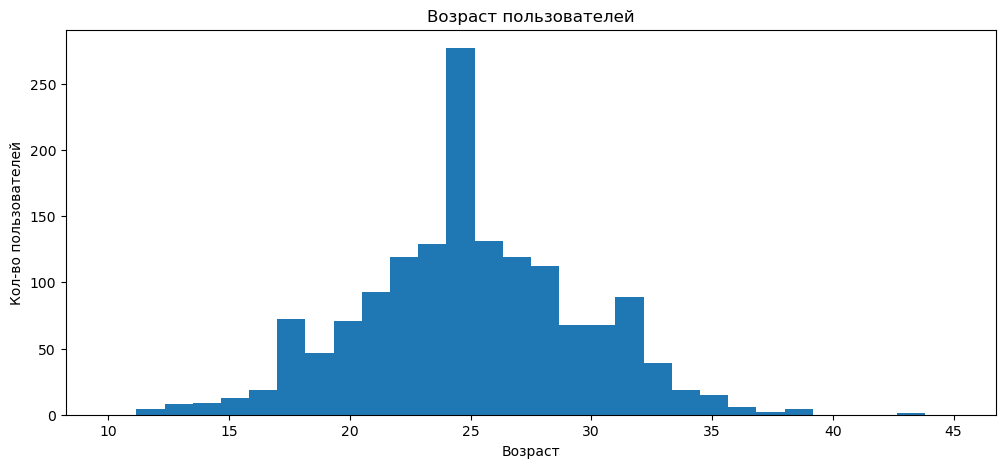

In [19]:
users_go['age'].plot(kind='hist',bins=30, range=(10,45), figsize=(12,5), title='Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Кол-во пользователей')
plt.show()

Интересная картина, по графику видно, что есть пиковая точка в отметке ~ 24, что близко к нашей средней. 
Также кол-во пользователей до 24 растет, а после пиковой точки график идет на спад.
Думаю, можно сказать, что возраст пользователей близок к нормальному распределению.

Рассмотрим данные о расстоянии, которое пользователь преодолел за одну поездку

In [20]:
riders_go['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Судя по минимальному и максимальному значению, можно сделать вывод, что в данных есть выбросы, можно построить "ящик с усами"

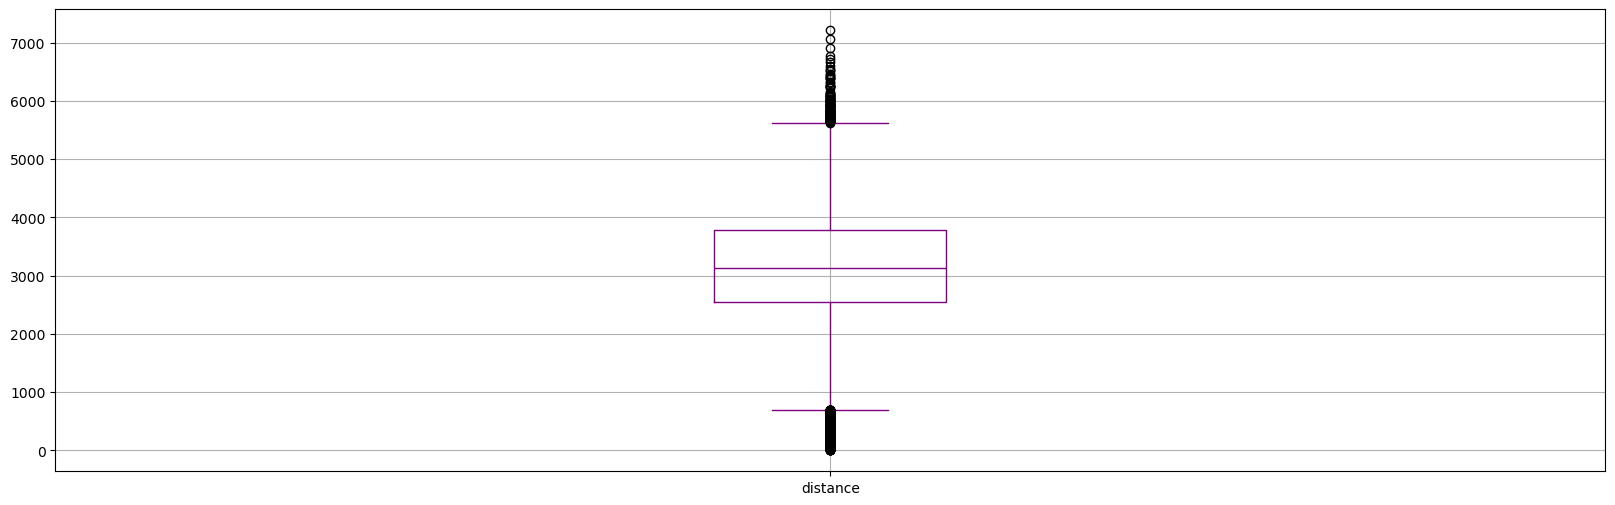

In [21]:
riders_go.boxplot('distance', color='purple',figsize=(20,6))
plt.show()

Итак, основная масса поездок колеблется в пределах от ~2500 до ~3800 м (1 и 3 квартили соотвественно) с медианной в 3130 м.
Медиана и ср значение примерно равны: 3130 и 3070. Выбросы есть, но необходимости их убирать нет.

Далее построим график продолжительности поездок

In [22]:
riders_go['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

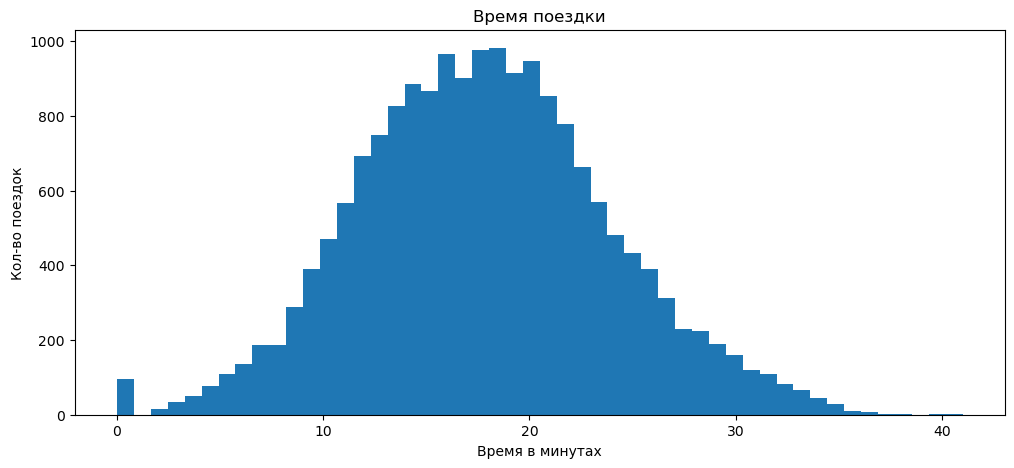

In [23]:
riders_go['duration'].plot(kind='hist', bins=50, range=(0,41),figsize=(12,5),title='Время поездки')
plt.xlabel('Время в минутах')
plt.ylabel('Кол-во поездок')
plt.show()

На графике виден рост кол-ва поездок до пиковой точки в ~18 минут, далее график идет на спад. Также не понятный пик у 0 минут, 


Дополнительно посмотрим на данные о поездках меньше 1 минуты

In [24]:
riders_go.loc[riders_go['duration'] <= 1]['duration'].describe()

count    95.0
mean      0.5
std       0.0
min       0.5
25%       0.5
50%       0.5
75%       0.5
max       0.5
Name: duration, dtype: float64

Так как в данных нет аномалий, оставим их. Видимо это какое то минимальное значение, на которое берется аренда. Также возможно это бронь самокатов с последующим отказом.

Проведя исследовательски анализ, можно сделать несколько выводов:
    
    1) Распределение городов одинковое. Во всех городах, где предоставлена услуга, люди пользуются самокатами примерно один-аково.
    
    2) Пользоваталей, у которых нет подписки, больше чем людей оформивших её. 
    Возможные причины: 
    -новые пользователи, которые только знакомятся с услугой;    
    -возможно у многих, просто скачано приложение, но они им не пользуются;
    -пользователи, которые не ознакомились с преимуществами подписки и тд.
    
    3) Около половины пользователей имеют возраст от 22 до 28, с пиковой точкой в 24 года. Здесь все просто, услуга пользуе-тся популярностью у молодежи, так как это относительно доступное и дешевое транспортное средство, так еще и веселое.
    
    4) Что касается дистанции, то здесь основная масса данных колеблется в диапозоне от 2.5 до 3.8 км. Предполагаю, что это примерное расстояние от дома до работы у большинства людей. 
    
    5) Последний график связан с временем поездки. Здесь бОльшая часть данных в диапозоне от 13 до 21 минуты, с пиковой точ-кой примерно у 17-18 минут. Некоторое кол-во поездок у 0 минут возможно связано с неисправностью самоката, либо же стра-хом управления у новых пользователей.

## Объединение данных

Объединяем данные о пользователях, поездках и подписках в один датафрейм.

1) Сперва объединяем данные таблиц riders_go и обновленной users_go, очищенную от дубликатов ( объединяем таблицы путем совмещения всех данных - outer, т.к. в датафрейме riders_go больше строк, а в users_go содержиться информация о всех пользователей, то данные о пользователях, которые не совершали поездки могут затерятся).

In [25]:
main_list = riders_go.merge(users_go, on = 'user_id', how='outer')

Взглянем на данные, где есть пропущенные значения

In [26]:
main_list.isna().sum()

user_id              0
distance             0
duration             0
date                 0
month                0
year                 0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

2) Далее присоединяем инфо с таблицы subscription_go к нашему новому датафрейму

In [27]:
main_list = main_list.merge(subscriptions_go, on = 'subscription_type', how='left')

Взглянем на итоговый датафрейм

In [28]:
display(main_list.head(5),
       main_list.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int32         
 5   year               18068 non-null  int32         
 6   name               18068 non-null  object        
 7   age                18068 non-null  int64         
 8   city               18068 non-null  object        
 9   subscription_type  18068 non-null  object        
 10  minute_price       18068 non-null  int64         
 11  start_ride_price   18068 non-null  int64         
 12  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(2), int64(5), object(

,user_id,distance,duration,date,month,year,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,2021,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,2021,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,2021,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,2021,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,2021,Кира,22,Тюмень,ultra,6,0,199


None

Чтобы проверить успешность слияния таблиц. Для начала проверим данные на пропуски.

In [29]:
main_list.isna().sum()

user_id              0
distance             0
duration             0
date                 0
month                0
year                 0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков нет. Также проверим кол-во строк итогового датафрейма с исходной таблицей raiders_go

In [30]:
main_list['distance'].count() == riders_go['distance'].count()

True

Ну и дубликаты на всякий случай

In [31]:
main_list.duplicated().sum()

0

Отлично! Идем дальше!

Далее создаем два датафрейма пользователей с подпиской и без неё

In [32]:
subscription_free = main_list.query('subscription_type == "free"').reset_index(drop=True)

In [33]:
subscription_ultra = main_list.query('subscription_type =="ultra"').reset_index(drop=True)

In [34]:
display(subscription_free.head(5),
       subscription_ultra.head(5))

,user_id,distance,duration,date,month,year,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,700,2515.690719,14.944286,2021-01-02,1,2021,Айдар,22,Омск,free,8,50,0
1,700,846.932642,16.234663,2021-02-01,2,2021,Айдар,22,Омск,free,8,50,0
2,700,4004.434142,20.016628,2021-02-04,2,2021,Айдар,22,Омск,free,8,50,0
3,700,1205.911290,9.782872,2021-02-10,2,2021,Айдар,22,Омск,free,8,50,0
4,700,3047.379435,17.427673,2021-02-14,2,2021,Айдар,22,Омск,free,8,50,0


,user_id,distance,duration,date,month,year,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,2021,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,2021,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,2021,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,2021,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,2021,Кира,22,Тюмень,ultra,6,0,199


Также првоеряем сумму строк, получившихся датафреймов с основным

In [35]:
subscription_free['distance'].count() + subscription_ultra['distance'].count() == main_list['distance'].count()

True

Визуализируем информацию о расстоянии и времени поездок для обеих категорий. Для удобства будем сравнивать две гистограммы одних и тех же параметров у разных типо подписок.

1) Сравним гистограммы продолжительности поездок

In [36]:
display(subscription_free['distance'].describe(),
subscription_ultra['distance'].describe())

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

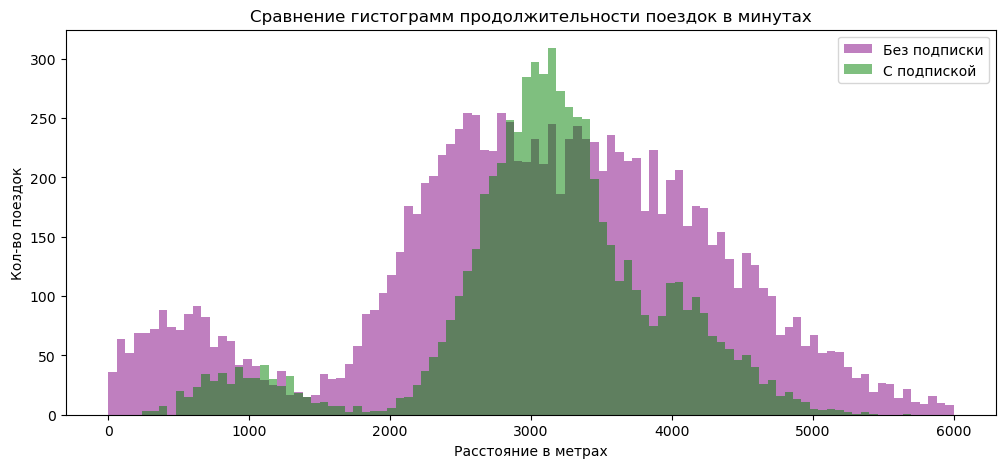

In [37]:
subscription_free['distance'].plot(kind='hist',bins=100, range=(0,6000),alpha=0.5, figsize=(12,5),legend=True,label='Без подписки',color='purple')
subscription_ultra['distance'].plot(kind='hist',bins=100, range=(0,6000), alpha=0.5, figsize=(12,5),title=('Сравнение гистограмм продолжительности поездок в минутах'),legend=True,label='С подпиской',color='g')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Кол-во поездок')
plt.show()

В первую очередь, бросается в глаза, что общее кол-во поездок у пользователей без подписки больше. Несмотря на это, видно что пик у пользователей с подписки больше, и он ярко выражен на отметке в ~3150 м. Также можно заметить, что с подпиской, что без неё, есть рост и падение графика до 2 км. У клиентов без подписки, можно наблюдать также, что они более часто ездят на длительные расстояния. Также немаловажно, что основная часть наблюдений у пользователей без подписки находится в диапозоне от 2300 до 3900 м., в то время как у подписчиков от 2700 до 3500 м. Это говорит о том, что пользователи с подпиской берут самокаты для определенной цели, возможно это поездка до метро или до работы, а пользователи без подписки могут взять самокат и для развлечения о чем говорят более длительные поездки.

2) Рассмотрим гистограммы продолжительности поездок

In [38]:
display(subscription_free['duration'].describe(),
subscription_ultra['duration'].describe())

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

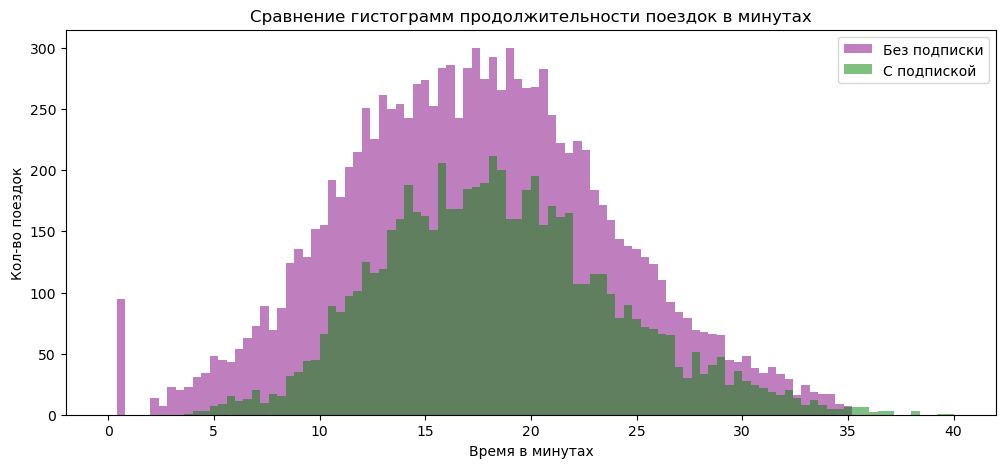

In [39]:
subscription_free['duration'].plot(kind='hist',bins=100, range=(0,40),alpha=0.5, figsize=(12,5),legend=True,label='Без подписки',color='purple')
subscription_ultra['duration'].plot(kind='hist', bins=100,range=(0,40), alpha=0.5, figsize=(12,5),title=('Сравнение гистограмм продолжительности поездок в минутах'),legend=True,label='С подпиской',color='g')
plt.xlabel('Время в минутах')
plt.ylabel('Кол-во поездок')
plt.show()

Здесь мы имеем, немного другую ситуацию. Пика у 0 минут у пользователей с подпиской нету (возможно у них неограниченное кол-во аренды, или же у них нет мин. ограничения на поездки). Подписчики могут быть в поездке более длительное время, чем пользователи без подписки.
Также видно, что минимальное значение у пользователей с подпиской является ~3.5 минуты, в то время как пользователи без подписки могут брать аренду и на менее длительное время. Судя по описанию данных, видно, что средняя продолжительность поездки у подписчиков больше на ~1 мин. Стоит отметить, что 1 квартиль у разных подписок разный, у пользователей без подписки он меньше и составляет ~13 минут, а у подписчиков ~14.5 минут.

Взглянем как ведут себя зависимости расстояния поездок от их времени у разных типов подписок

1) Пользователи с подпиской

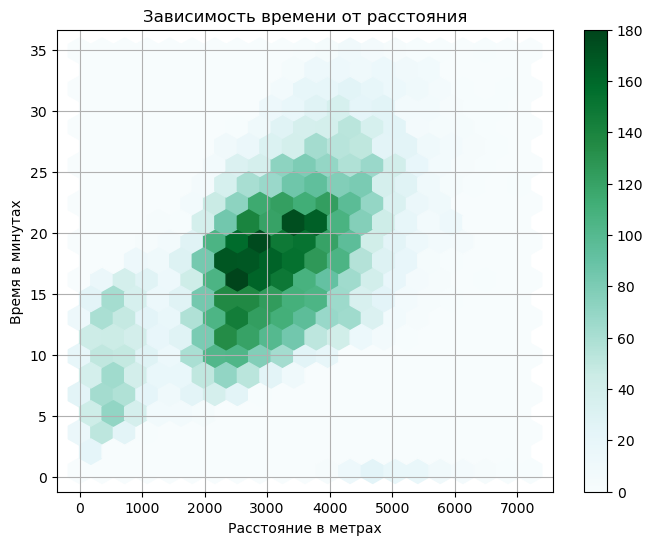

In [40]:
subscription_free.plot(x='distance',y='duration', kind='hexbin',gridsize=20, figsize=(8,6),sharex=False, grid=True,title='Зависимость времени от расстояния')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Время в минутах')
plt.show()


2) Пользователи без подписки

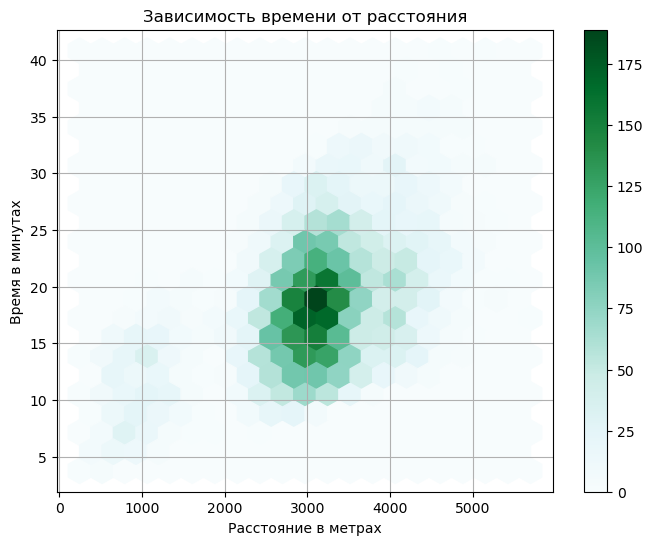

In [41]:
subscription_ultra.plot(x='distance',y='duration', kind='hexbin', gridsize=20, figsize=(8,6), sharex=False, grid=True,title='Зависимость времени от расстояния')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Время в минутах')
plt.show()

По итогам данного шага:
    
    1) Сформировали один большой датафрейм с информацией о поездках и пользователях, а также доп информация о подписке;
    2) Создали два датафрейма по критерию подписки: пользователи с подпиской и без неё;
    3) Рассмотрели графики duration и distance у двух датафреймов
    4) Касаемо различий у поездок с/без подписки:
        -поездок без подписки больше почти в два раза;
        -среднее расстояние поездок примерно одинковое;
        -максмальное расстояние у поездки без подписки (7211 против 5669 м);
        -однако время поездки у пользователей с подпиской все же больше, хоть и не намного: среднее значение отличается на ~1 минуту(однако у пользователей без подписки, есть поездки равные меньше минуты)

## Подсчёт выручки

Создадим датафрейм с агрегрованными данными о поездках по пользователям. Но перед этим необходимо округлить минуты до следующего целого числа в исходном датафрейме с инфо. о поездках.

In [42]:
main_list['duration'] = np.ceil(main_list['duration'])
users_travel_info = main_list.pivot_table(index=('month','user_id'), values=('distance', 'duration'), aggfunc=('sum'))
users_travel_info['count'] = main_list.pivot_table(index=('month','user_id'), values='duration', aggfunc='count')

In [43]:
users_travel_info.head(10)

distance  duration  count
month user_id                              
1     1        7027.511294      42.0      2
      3        3061.777147      13.0      1
      5        3914.646990      13.0      1
      7        6478.080979      28.0      2
      12       3577.151148      33.0      1
      13       6687.987446      42.0      2
      14       7699.643820      35.0      2
      15       4187.621459      39.0      1
      20       3516.719208      29.0      1
      22       3058.692225      13.0      1

Добавим столбец с типом подписки у пользователя

In [44]:
users_travel_info['subscription_type'] = main_list.pivot_table(index=('month','user_id'), values='subscription_type', aggfunc='first')

In [45]:
users_travel_info.head(5)

distance  duration  count subscription_type
month user_id                                                
1     1        7027.511294      42.0      2             ultra
      3        3061.777147      13.0      1             ultra
      5        3914.646990      13.0      1             ultra
      7        6478.080979      28.0      2             ultra
      12       3577.151148      33.0      1             ultra

In [46]:
def income(row):
    if row['subscription_type'] == 'ultra':
        return 199+row['duration']*6
    elif row['subscription_type'] == 'free':
        return 50*row['count']+row['duration']*8
    else: 'No info'
users_travel_info['income_per_month'] = users_travel_info.apply(income, axis=1)

In [47]:
users_travel_info.head(10)

distance  duration  count subscription_type  \
month user_id                                                   
1     1        7027.511294      42.0      2             ultra   
      3        3061.777147      13.0      1             ultra   
      5        3914.646990      13.0      1             ultra   
      7        6478.080979      28.0      2             ultra   
      12       3577.151148      33.0      1             ultra   
      13       6687.987446      42.0      2             ultra   
      14       7699.643820      35.0      2             ultra   
      15       4187.621459      39.0      1             ultra   
      20       3516.719208      29.0      1             ultra   
      22       3058.692225      13.0      1             ultra   

               income_per_month  
month user_id                    
1     1                   451.0  
      3                   277.0  
      5                   277.0  
      7                   367.0  
      12                  397.0  
      13                  451.0  
      14                  409.0  
      15                  433.0  
      20                  373.0  
      22                  277.0

По итогам данного шага:

    1) Создали датафрейм с информацией по месяцам по каждому пользователю о его суммарном расстоянии и длительности поездок;
    2) Рассчитали выручку по месяцам по каждому пользователю, учитываю подписку

## Проверка гипотез

Итак, продакт менеджерам необходимо увеличить кол-во подписок. Перед этим необходимо проверить несколько гипотез

1) "Тратят ли пользователи с подпиской больше времени на поездки, чем без неё".
    Сформулируем гипотезы:
    
        H0 - ср. время поездки пользователей с подпиской = ср. времени поездки у пользователей без неё(нулевая гипотеза)
        H1 - ср. время поездки пользователей с подпиской > ср. времени поездки пользователей без неё(альтернативная гипотеза)
        
alpha - 0.05

In [48]:
ultra = subscription_ultra['duration']
free = subscription_free['duration']
print(f'среднее первой выборки: {np.mean(ultra)}')
print(f'среднее второй выборки:{np.mean(free)}')
result1 = st.ttest_ind(ultra,free,alternative='greater')
alpha= 0.05
print('p-значение:', result1.pvalue)
if result1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

среднее первой выборки: 18.54198516280583
среднее второй выборки:17.39090929866399
p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Таким образом, при проведении т-теста, с уровнем значимости в 5%, мы можем опровергнуть нулевую гипотезу и сделать вывод, что она не верна, поэтому есть основания утверждать, что среднее время поездки пользователей с подпиской выше чем у пользователей без подписки.

2) Проверяем гипотезу о среднем расстоянии поездки для пользователей с подпиской,что оно не превышает 3130 м:

    H0 - ср. расстояние поездки пользователей с подпиской = 3130 метров (нулевая гипотеза)
    H1 - ср. расстояние поездки пользователей с подпиской > 3130 метров (альтернативная гипотеза)

alpha - 0.05


In [49]:
distance_ultra = subscription_ultra['distance']
print('Среднее выборки:',distance_ultra.mean())

value = 3130
alpha = 0.05

result2 = st.ttest_1samp(distance_ultra,value,alternative='greater')
print('p-значение:', result2.pvalue)
if result2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотзу')

Среднее выборки: 3115.4453880370247
p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотзу


Выборочное среднее равно 3115 и отличается от 3130, предположенного в нулевой гипотезе. Однако отличие не слишком велико, чтобы опровергнуть нулевую гипотезу, что истинное среднее и предположенное не равны при уровне значимости в 5%. Таким образом, есть основание утверждать, что среднее расстояние, проезжаемое пользовалеями с подпиской, не превышает 3130 метров, а значитоно в пределах нормы износа самокатов.


3) Проверим гипотезу, что помесячная выручка пользователей с подпиской выше, чем у пользователей без подписки:
    
    H0 - ср. выручка по месяцам у пользователей с подпиской = ср. выручке по месяцам у пользователей без подписки;
    H1 - ср. выручка по месяцам у пользователей с подпиской > чем ср. выручка по месяцам у пользователей без подписки
    
alpha = 0.05

In [50]:
ultra_per_month = users_travel_info.loc[users_travel_info['subscription_type'] == 'ultra', 'income_per_month']
free_per_month = users_travel_info.loc[users_travel_info['subscription_type'] == 'free', 'income_per_month']
alpha = 0.05
print(f'среднее первой выборки: {np.mean(ultra_per_month)}')
print(f'среднее второй выборки: {np.mean(free_per_month)}')

result3 = st.ttest_ind(ultra_per_month,free_per_month,alternative='greater')
print('p-значение:', result3.pvalue)

if result3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


среднее первой выборки: 362.7921906022502
среднее второй выборки: 328.6413651073845
p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Проведя т-тестирование, можно сказать, что при уровне значимости в 5% альтернативную гипотезу о том, что среднее первой выборки больше чем среднее второй выборки,не стоит отвергать 

4) При проведении гипотезы о том, что после обновления тех. обращения пользователей снизились, выдвигаем гипотезы:

    H0 - среднее кол-во обращений пользователя до обновления = среднему кол-ву обращений пользователя после него;
    H1 - среднее кол-во обращение пользователя до обновления > среднему кол-ву обращений пользователя после него.
    
В данном случае t-тест проводится для двух зависимых выборок с применением метода st.ttest_rel

По итогам проверки гипотез:
    
    1) Гипотеза о том, что пользователь тратит больше времени на поездки с подпиской чем без неё опровергнута в пользу альт-ернативной гипотезы.При уровне значимости в 5% мы не можем удтверждать,что пользователь с подпиской тратит такое же вре-мя на поездки как пользователь без неё.  
    
    2) Вторая гипотеза о том, что среднее расстояние поездки у пользователей с подпиской равно 3130 не может быть опровергн-ута, хоть и с различающимя значением самой выборки (3115 м) с урвонем значимости в 5%.
    
    3) Гипотеза, что пользователь с подпиской в месяц приносит выручку, равную выручке пользователя без подписки, опровергн-ута в пользу альтернативной гипотезы с уровнем значимости в 5%.

## Вывод
По итогам данного исследования: 

1) На входе получили исходные данные, а именно три файла с информацией о пользователях, поездках, а также информацией о видах подписки. Исходные данные были без пропусков, а также имели малое кол-во дубликатов (31 в таблице с пользователями), но кол-во строк в таблицах сильно различались, что логично, на дальнейший анализ это никак не повлияло. Открыв файлы csv и изучив информацию о данных в таблицах, только в единственном столбце был некорректный тип данных, который был изменен сл. шаге.

2) Далее по итогам предобратки данных, добавили столбцы с номером месяца и скорректировали тип данных в столбце date. Удалили дубликаты в таблице с информацией о пользователях.

3) В ходе исследовательского анализа изучили такие переменные как: город, тип подписки, расстояние и время поездки. В целом данные хорошо распределены и нет каких то сильно выбивающихся значений и аномалий. Выяснили, что в городах, где предоставлена услуга проката самоката, примерно равное кол-во поездок, основная масса поездок это 2.5 - 3.7 км расстояния, примерно за 13 - 20 минут. Основными пользователями услуги является молодые люди от 22 до 28 лет, но есть и пользователи, чей возраст может достигать 43 лет. Также людей, предпочитающих пользоваться услугой с подпиской больше на 8.8%.

4) В ходе 4-го шага объеденили все три исходных таблицы в общую и сформировали единый датафрейм с информацией о пользователях, их поездках и типах подписок, также создали два датафрейма по типу подписки. Посмотрели как ведут себя переменные расстояния и времени поездок у людей с разными типами subscription. Выяснили, что люди с подпиской обычно дольше ездят (на ~1 минуту), среднее расстояние примерно одинаковое, но поездок без подписки больше почти в два раза.

5) Далее создали датафрейм с агрегорванными данными о времени и расстоянии поездок по месяцам и id пользователей. Используя информацию о подписках, подсчитали объем выручки, который приносит каждый пользователь по месяцам.

6) Кульминацией данного исследования была првоерка трех гипотез:

-Тратят ли пользователи с подпиской больше времени на поездки, чем без неё;

-Равно ли среднее расстояние поездок у пользователей с подпиской 3130 метрам;

-Пользователь с подпиской приносит больше выручки чем пользователь без подписки.

Используя уровень значимости в 5%, опровергнуть не получилось лишь только гипотезу о среднем расстоянии пользователей с подпиской равному 3130 м, все остальные гипотезы были опровергнуты в пользу альтернативных. Это значит, что возможно пользователи с подпиской и в правду приносят больше выручки, а также скорее всего пользователи с подпиской тратя больше времени на поездку, чем другая группа пользователей.


Как известно, в данных обычно часто встречаются пропуски и дубликаты, однако в нашем случае, необходимо было только скорректировать тип данных в 1 столбце и удалить 31 дубликат в 1 таблице. Также добавив 1 столбец с номером месяца, можно более детально изучить данные, сгруппировав их по месяцам. Для удобства объеденили все таблицы в 1 общую, однако есть вероятность, что при ведении такой единой базы, шанс дубликатов и пропусков увеличивается, что в последствии усложнит работу с данными. Из полезного можно создать датафрейм, с пользователями по месяцам, их общего расстояния и временем поездок для рассчета прибыли с пользователя. Однако здесь стоит учитывать, что пользователи могут оформлять подписку не в начале месяца, а допустим в середине, при этом нет информации о том, какой тип подписки будет у пользователя в месяц оформления и в следующий месяц, что может некорректно отразиться на рассчете прибыли.

Таким образом, получив на входе довольно "чистые" и хорошо структурированные данные, мы проверили несколько гипотез, выдвинутые продакт-менеджерами, часть из которых подтвердилась.

<div style="border:solid lightblue 3px; background:#f7faf8; padding: 20px">
<span style="color:darkblue">Общий вывод по проекту v_3:</span>
    
Спасибо за доработанные замечания! Проект принят. В дополнение по данной [ссылке](https://allatambov.github.io/psms/pdf/hypo-test.pdf) можно ознакомиться с очень понятной краткой теорией по проверке гипотез.
    
Успехов в дальнейшем обучении!)